# CNN

In [1]:
import dlc_bci as bci
import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

In [2]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, '--', c=c[0], label='Train loss')
    plt.plot(val_losses, c=c[0], label='Val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(train_accs, '--', c=c[1], label='Train acc')
    plt.plot(val_accs, c=c[1], label='Val acc')
    plt.legend(loc='best')

## 1 Loading and transforming the data

In [3]:
train_input, train_target = bci.load(root = './data_bci', train=True, one_khz=True)
print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])


In [4]:
test_input, test_target = bci.load(root = './data_bci', train=False, one_khz=True)
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])


In [5]:
train_input.shape

torch.Size([316, 28, 500])

In [6]:
train_input = train_input.permute(0,2,1)
test_input = test_input.permute(0,2,1)

In [7]:
train_input.shape, test_input.shape

(torch.Size([316, 500, 28]), torch.Size([100, 500, 28]))

## 1.2 Data augmentation

In [8]:
def augment_dataset(train_input, train_target, std_dev, multiplier):
    new_train_input = train_input.clone()
    new_train_target = train_target.clone()
    for i in range(multiplier-1):
        augmented_input = train_input + torch.zeros(train_input.shape).normal_(0, std_dev)
        new_train_input = torch.cat((new_train_input, augmented_input))
        new_train_target = torch.cat((new_train_target, train_target))
    return new_train_input, new_train_target

In [19]:
train_input, train_target = augment_dataset(train_input, train_target, 0.1, 30)

## 1.3 Creating the Dataset / Dataloader

In [20]:
train_dataset = TensorDataset(train_input, train_target)
test_dataset = TensorDataset(test_input, test_target)

In [21]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
dset_loaders = {'train': trainloader, 'val': testloader}
dset_sizes = {'train': len(train_input), 'val': len(test_input)}

## 2 Defining the model architecture

In [11]:
train_input.shape

torch.Size([316, 500, 28])

In [12]:
#seq = train_input.shape[1] # 500
#input_size = train_input.shape[2] #28

class Net(torch.nn.Module):
    def __init__(self, n_time_steps, n_features):
        super(Net, self).__init__()
        
        n_hidden = 256
        
        # Conv input size is: (batch, feature(as channels), seq)
        # Conv output size is: (batch, new_channels, seq_2)
        self.conv3a = torch.nn.Conv1d(in_channels=n_features,
                                      out_channels=64,
                                      kernel_size=3,
                                      padding=1)
        self.conv3b = torch.nn.Conv1d(in_channels=64,
                                      out_channels=1,
                                      kernel_size=3,
                                      padding=1)
        
        self.conv5 = torch.nn.Conv1d(in_channels=n_features,
                                    out_channels=1,
                                    kernel_size=5,
                                    padding=2)
        self.conv7 = torch.nn.Conv1d(in_channels=n_features,
                                    out_channels=1,
                                    kernel_size=7,
                                    padding=3)
        
        self.fc1 = torch.nn.Linear(n_time_steps, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, 2)

    def forward(self, x):
        x = x.permute(0,2,1)
        
        c3 = F.relu(self.conv3a(x))
        c3 = F.relu(self.conv3b(c3))
        c3 = c3.view(c3.shape[0], -1)
        x = c3
        
        #c5 = F.relu(self.conv5(x))
        #c5 = c5.view(c5.shape[0], -1)
        
        #c7 = F.relu(self.conv7(x))
        #c7 = c7.view(c7.shape[0], -1)
        
        #x = torch.cat((c3, c5, c7), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## 3 Training models

In [13]:
batch_size = 32

In [14]:
def train_model(model, dset_loaders, dset_sizes, criterion, optimizer,\
                lr_scheduler=None, num_epochs=25, verbose=2):
    since = time.time()

    best_model = model
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        if verbose > 1:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if lr_scheduler:
                    optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                preds_classes = preds.data.max(1)[1]
                running_corrects += torch.sum(preds_classes == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if verbose > 1:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        if verbose > 1: 
            print()

    time_elapsed = time.time() - since
    if verbose > 0:
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
    return best_model, train_losses, val_losses, train_accs, val_accs

In [15]:
def k_fold_cv(model, train_input, train_target, criterion, optimizer, lr_scheduler=None,\
              num_epochs=25, K=5, shuffle=True, random_seed=42, verbose=2,
              augment_multiplier=0, std_dev=0.1):
    n_train = len(train_input)
    indices = list(range(n_train))
    n_validation = n_train // K
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    avg_train_loss, avg_val_loss = 0, 0
    avg_train_acc, avg_val_acc = 0, 0
        
    for k in range(K):
        indices_rolled = np.roll(indices, k * n_train // K)
        train_idx, val_idx = indices_rolled[n_validation:], indices_rolled[:n_validation]
        
        train_inp = train_input[train_idx,]
        train_tar = train_target[train_idx,]
        val_inp = train_input[val_idx,]
        val_tar = train_target[val_idx,]
        
        train_inp, train_tar = augment_dataset(train_inp, train_tar, std_dev, augment_multiplier)
        
        #train_sampler = SubsetRandomSampler(train_idx) #sampler=train_sampler
        #val_sampler = SubsetRandomSampler(val_idx) #sampler=val_sampler
        
        train_dataset = TensorDataset(train_inp, train_tar)
        val_dataset = TensorDataset(val_inp, val_tar)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        dset_loaders = {'train': train_loader, 'val': val_loader}
        dset_sizes = {'train': len(train_inp), 'val': len(val_inp)}
        
        if verbose:
            print('CV k={}:'.format(k))
        _, train_losses, val_losses, train_accs, val_accs = train_model(copy.deepcopy(model), dset_loaders, 
                                                                        dset_sizes, criterion, optimizer, 
                                                                        num_epochs=num_epochs, verbose=verbose)
        
        avg_train_loss += min(train_losses)
        avg_val_loss += min(val_losses)
        avg_train_acc += max(train_accs)
        avg_val_acc += max(val_accs)
        
    avg_train_loss /= K
    avg_val_loss /= K
    avg_train_acc /= K
    avg_val_acc /= K
        
    if verbose:
        print('\nAvg best train loss: {:.2f}, avg best val loss: {:.2f}'.format(avg_train_loss, avg_val_loss))
        print('Avg best train acc: {:.6f}%, avg best val acc: {:.6f}%'.format(avg_train_acc*100, avg_val_acc*100))
        
    return avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc

### Test blabla

In [22]:
model = Net(train_input.shape[1], train_input.shape[2])
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
weight_decay = 1e-1 # L2 regularizer parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

In [23]:
best_model, train_losses, val_losses, train_accs, val_accs = train_model(model, dset_loaders, dset_sizes,\
                                                                         criterion, optimizer, num_epochs=250,\
                                                                         verbose=2)

Epoch 0/249
----------
train Loss: 0.0204 Acc: 0.5685
val Loss: 0.0346 Acc: 0.5200

Epoch 1/249
----------
train Loss: 0.0158 Acc: 0.7026
val Loss: 0.0403 Acc: 0.5900

Epoch 2/249
----------
train Loss: 0.0120 Acc: 0.8249
val Loss: 0.0532 Acc: 0.6000

Epoch 3/249
----------
train Loss: 0.0098 Acc: 0.8840
val Loss: 0.0587 Acc: 0.6300

Epoch 4/249
----------
train Loss: 0.0082 Acc: 0.9133
val Loss: 0.0628 Acc: 0.5900

Epoch 5/249
----------
train Loss: 0.0075 Acc: 0.9175
val Loss: 0.0521 Acc: 0.6300

Epoch 6/249
----------
train Loss: 0.0067 Acc: 0.9254
val Loss: 0.0555 Acc: 0.6600

Epoch 7/249
----------
train Loss: 0.0058 Acc: 0.9397
val Loss: 0.0641 Acc: 0.6700

Epoch 8/249
----------
train Loss: 0.0056 Acc: 0.9464
val Loss: 0.0539 Acc: 0.6200

Epoch 9/249
----------
train Loss: 0.0050 Acc: 0.9557
val Loss: 0.0496 Acc: 0.6300

Epoch 10/249
----------
train Loss: 0.0051 Acc: 0.9573
val Loss: 0.0532 Acc: 0.6700

Epoch 11/249
----------
train Loss: 0.0044 Acc: 0.9682
val Loss: 0.0441 Acc

val Loss: 0.1282 Acc: 0.5700

Epoch 97/249
----------
train Loss: 0.0017 Acc: 0.9968
val Loss: 0.1285 Acc: 0.5400

Epoch 98/249
----------
train Loss: 0.0022 Acc: 0.9911
val Loss: 0.1158 Acc: 0.5400

Epoch 99/249
----------
train Loss: 0.0018 Acc: 0.9960
val Loss: 0.1235 Acc: 0.5500

Epoch 100/249
----------
train Loss: 0.0017 Acc: 0.9967
val Loss: 0.1272 Acc: 0.5400

Epoch 101/249
----------
train Loss: 0.0017 Acc: 0.9967
val Loss: 0.1250 Acc: 0.5400

Epoch 102/249
----------
train Loss: 0.0017 Acc: 0.9968
val Loss: 0.1355 Acc: 0.5300

Epoch 103/249
----------
train Loss: 0.0020 Acc: 0.9935
val Loss: 0.1242 Acc: 0.4800

Epoch 104/249
----------
train Loss: 0.0017 Acc: 0.9966
val Loss: 0.1305 Acc: 0.5100

Epoch 105/249
----------
train Loss: 0.0017 Acc: 0.9966
val Loss: 0.1241 Acc: 0.5200

Epoch 106/249
----------
train Loss: 0.0017 Acc: 0.9967
val Loss: 0.1318 Acc: 0.5400

Epoch 107/249
----------
train Loss: 0.0017 Acc: 0.9963
val Loss: 0.1227 Acc: 0.5400

Epoch 108/249
----------
tr

train Loss: 0.0004 Acc: 1.0000
val Loss: 0.0682 Acc: 0.6800

Epoch 193/249
----------
train Loss: 0.0005 Acc: 0.9992
val Loss: 0.0685 Acc: 0.6700

Epoch 194/249
----------
train Loss: 0.0005 Acc: 0.9992
val Loss: 0.0726 Acc: 0.6800

Epoch 195/249
----------
train Loss: 0.0004 Acc: 0.9998
val Loss: 0.0670 Acc: 0.6600

Epoch 196/249
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.0651 Acc: 0.6700

Epoch 197/249
----------
train Loss: 0.0004 Acc: 0.9999
val Loss: 0.0665 Acc: 0.6700

Epoch 198/249
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.0691 Acc: 0.6600

Epoch 199/249
----------
train Loss: 0.0004 Acc: 0.9998
val Loss: 0.0685 Acc: 0.6600

Epoch 200/249
----------
train Loss: 0.0005 Acc: 0.9997
val Loss: 0.0690 Acc: 0.6500

Epoch 201/249
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.0687 Acc: 0.6600

Epoch 202/249
----------
train Loss: 0.0004 Acc: 0.9998
val Loss: 0.0687 Acc: 0.6600

Epoch 203/249
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.0679 Acc: 0

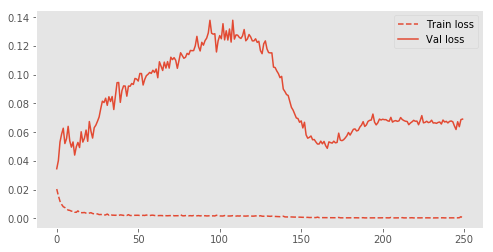

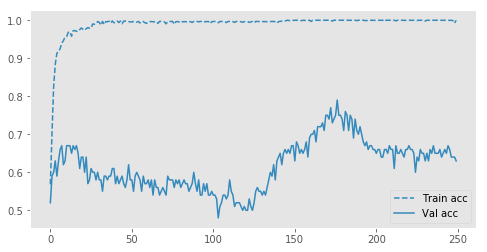

In [24]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

In [ ]:
_,_,_,_ = k_fold_cv(model, train_input, train_target, criterion, optimizer, 
                    num_epochs=250, K=5, shuffle=True, random_seed=42, verbose=1,
                    augment_multiplier=0, std_dev=0.1)

In [ ]:
train_input_var = Variable(train_input.cuda())
train_target_var = Variable(train_target.cuda(), requires_grad=False)

test_input_var = Variable(test_input.cuda())
test_target_var = Variable(test_target.cuda(), requires_grad=False)

In [ ]:
pred_test = best_model(test_input_var).data
pred_test_classes = pred_test.max(1)[1]
accuracy_score(pred_test_classes, test_target)

In [ ]:
pred_train = best_model(train_input_var).data
pred_train_classes = pred_train.max(1)[1]
accuracy_score(pred_train_classes, train_target)